In [1]:
import os
import datetime
import numpy as np

In [2]:
import tensorflow as tf
import tf_keras
from tf_keras.layers import Input,Dense
from tf_keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose,concatenate
from tf_keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tf_keras.callbacks import LearningRateScheduler,ModelCheckpoint
import tf_keras.backend as K
from tf_keras.losses import categorical_crossentropy
from tf_keras.preprocessing.image import ImageDataGenerator
from tf_keras import layers

In [33]:
import tensorflow as tf
from tf_keras.layers import Input,Dense
from tf_keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose,Conv3D,DepthwiseConv2D,DepthwiseConv1D
from tf_keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tf_keras.callbacks import LearningRateScheduler,ModelCheckpoint
import tf_keras.backend as K
from tf_keras.preprocessing.image import ImageDataGenerator
from tf_keras import layers

In [4]:
import tempfile
import tensorflow_model_optimization as tfmot
from tf_keras.applications.mobilenet_v2 import MobileNetV2


In [5]:
import glob
filename = glob.glob(r'DeepLearningBasedTBDiagnosis/dataset/TBX11K/imgs/tb/*.*')
print(len(filename))
filename = glob.glob(r'DeepLearningBasedTBDiagnosis/dataset/TBX11K/imgs/sick/*.*')
print(len(filename))
filename = glob.glob(r'DeepLearningBasedTBDiagnosis/dataset/TBX11K/imgs/health/*.*')
print(len(filename))

0
0
0


In [ ]:
BATCH_SIZE = 16
IMG_SIZE = (256,256)

train_dir = 'dataset/TBX11K/imgs/train/'
test_dir = 'dataset/TBX11K/imgs/test/'

In [7]:
from dataset import define_data
from sklearn.preprocessing import LabelBinarizer
train = LabelBinarizer()

In [8]:
from dataset import define_data
train_data, train_y = define_data(train_dir,IMG_SIZE)
target_val = train.fit_transform(train_y)

loading 500th image for class health
loading 500th image for class sick
loading 500th image for class tb


In [ ]:
test_size=0.15
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(train_data, ),target_val,test_size=test_size,random_state=42)

In [10]:
back_net = MobileNetV2
net = "MobileNetV2"

In [94]:
def model(input_shape):
    inputs = Input(shape=input_shape,name="input_image")
    base_model = back_net(input_tensor = inputs, weights="imagenet", include_top=False, alpha=0.35)
    #base_model.trainable=False
    x=base_model.output
    x=GlobalAveragePooling2D(name="gap")(x)
    output=Dense(3,activation="softmax")(x)
    return tf_keras.Model(inputs,output)

In [95]:
#the steps of this are vaguely unclear to me - i.e., do I need to compile again? is load_weights sufficient? time to research
base_model = model(input_shape=(256,256,3))
base_model.load_weights('mobilnet-output/class_weights.06-0.96.weights.h5')
base_model.compile(optimizer=tf_keras.optimizers.Adam(),
              loss=tf_keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

In [96]:
batch_size = 16
epochs = 10
#test_size exists
image_num = x_train.shape[0] * (1-test_size)
end_step = np.ceil(image_num / batch_size).astype(np.int32) * epochs
print(image_num, end_step)

1677.8999999999999 1050


In [30]:
filepath=f'{back_net.__name__}/pruned/class_weights.{{epoch:02d}}-{{val_loss:.2f}}.weights.h5'

In [ ]:
callbacks = [
    tf_keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        save_best_only=True,save_weights_only=True,verbose=1),
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir="./logs")
]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(teacher)
pruned_tflite_model = converter.convert()

pruned_tflite_file=f'{back_net.__name__}.tflite'

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: C:\Users\maddi\AppData\Local\Temp\tmp5_d_e24l\assets


INFO:tensorflow:Assets written to: C:\Users\maddi\AppData\Local\Temp\tmp5_d_e24l\assets


Saved pruned TFLite model to: MobileNetV2.tflite


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(teacher)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

quantized_and_pruned_tflite_file=f'{back_net.__name__}.tflite'

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: C:\Users\maddi\AppData\Local\Temp\tmpaqfacmm0\assets


INFO:tensorflow:Assets written to: C:\Users\maddi\AppData\Local\Temp\tmpaqfacmm0\assets


Saved quantized and pruned TFLite model to: C:\Users\maddi\AppData\Local\Temp\tmpra11s0kf.tflite
Size of gzipped pruned and quantized TFlite model: 434449.00 bytes


In [51]:
interpreter = tf.lite.Interpreter(model_path=quantized_pruned_tflite_file)
interpreter.allocate_tensors()

input_details=interpreter.get_input_details()
output_details=interpreter.get_output_details()
print(input_details,output_details)

[{'name': 'serving_default_input_image:0', 'index': 0, 'shape': array([  1, 256, 256,   3]), 'shape_signature': array([ -1, 256, 256,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] [{'name': 'StatefulPartitionedCall:0', 'index': 172, 'shape': array([1, 3]), 'shape_signature': array([-1,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


c:\Users\maddi\Desktop\CS\project\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [62]:
def tflite_predict(image):
    interpreter.set_tensor(input_details[0]["index"],image[np.newaxis,...])
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]["index"])[0]

In [ ]:
batch = x_test[:BATCH_SIZE]

In [61]:
print(x_test.shape)

(349, 256, 256, 3)


In [66]:
from sklearn.metrics import confusion_matrix,classification_report

In [67]:
correct = 0
total = len(x_test)
y_true = []
y_pred = []

for i in range(total):
    preds = tflite_predict(x_test[i])
    y_pred.append(np.argmax(preds))
    y_true.append(np.argmax(y_test[i]))

print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred,target_names=train.classes_))

[[121   0   0]
 [ 32  48  24]
 [ 10   0 114]]
              precision    recall  f1-score   support

      health       0.74      1.00      0.85       121
        sick       1.00      0.46      0.63       104
          tb       0.83      0.92      0.87       124

    accuracy                           0.81       349
   macro avg       0.86      0.79      0.78       349
weighted avg       0.85      0.81      0.79       349



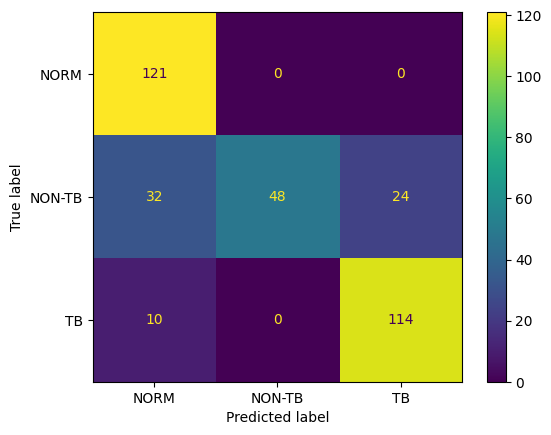

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true,y_pred,labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["NORM","NON-TB","TB"])
disp.plot()
plt.savefig(f"{back_net.__name__}prunequanttflite-confusionmatrix.png")
plt.show()